# Prediction of the number of migrations between two districts per year (GLS)

In [19]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

In [20]:
f_vector = pd.read_csv("../feature_extraction/data/feature_vector_complete.csv")

In [21]:
f_vector.columns

Index(['migrations', 'destination', 'origin', 'year', 'n_inhabitants_or',
       'net_income_or', 'dist_size_or', 'rev_1000_inh_or', 'var_review_or',
       'unemployed_or', 'eldery_perc_or', 'd_inner_n_or', 'd_outer_n_or',
       'var_n_biz', 'var_sale_m2_or', 'var_rent_m2_or', 'n_tran_rs_or',
       'n_tran_new_rs_or', 'mortage_executions', 'n_inhabitants_de',
       'net_income_de', 'dist_size_de', 'rev_1000_inh_de', 'var_review_de',
       'unemployed_de', 'eldery_perc_de', 'd_inner_n_de', 'd_outer_n_de',
       'var_sale_m2_de', 'var_rent_m2_de', 'n_tran_rs_de', 'n_tran_new_rs_de',
       'net_income_diff', 'dist_size_diff', 'rev_1000_inh_diff',
       'var_review_diff', 'unemployed_diff', 'eldery_perc_diff',
       'd_inner_n_diff', 'd_outer_n_diff', 'var_sale_m2_diff',
       'var_rent_m2_diff', 'n_tran_rs_diff', 'n_tran_new_rs_diff'],
      dtype='object')

### Scale continuous variables

In [105]:
features_to_scale = ['net_income_diff', 'dist_size_diff', 'rev_1000_inh_diff',
       'unemployed_diff', 'eldery_perc_diff', 'var_sale_m2_diff',
       'var_rent_m2_diff', 'n_tran_new_rs_diff',"n_tran_new_rs_or","n_tran_rs_de",
                            'dist_size_or','dist_size_de','net_income_or', 'rev_1000_inh_or', 
                            'unemployed_or','eldery_perc_or', 'var_n_biz','net_income_de', 'rev_1000_inh_de', 
                            'unemployed_de','eldery_perc_de', "var_sale_m2_or","var_rent_m2_or","var_sale_m2_de",
                            "var_rent_m2_de","n_tran_new_rs_or","n_tran_new_rs_de",
                            "mortage_executions"]

In [106]:
for feature in features_to_scale:
    scaler = StandardScaler()
    f_vector[feature] = scaler.fit_transform(f_vector[feature])

### Split train and test values with balanced migration values

In [107]:
# Split dataset into info, x and y
info_cols = ["origin","destination","year","migrations"]
info = f_vector.loc[:,(info_cols)]
X_degree = f_vector.loc[:,(features_to_scale_degree)]
X_wo_degree = f_vector.loc[:,(features_to_scale_wo_degree)]
y = f_vector.loc[:,"migrations"]

In [108]:
# Assign labels (quartile) to target in order to split balanced train/test datasets
labels = pd.qcut(f_vector["migrations"], 5, labels=["q1","q2","q3","q4","q5"]).tolist()

In [109]:
# Split train/test datasets
X_train_degree, X_test_degree, y_train, y_test = train_test_split(X_degree, y, train_size=0.8, random_state=32, 
                                                                  stratify=labels)
X_train_wo_degree, X_test_wo_degree, y_train, y_test = train_test_split(X_wo_degree, y, train_size=0.8, random_state=32, 
                                                                  stratify=labels)

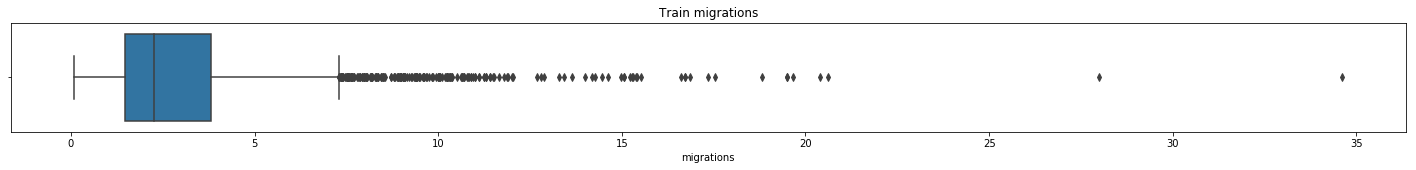

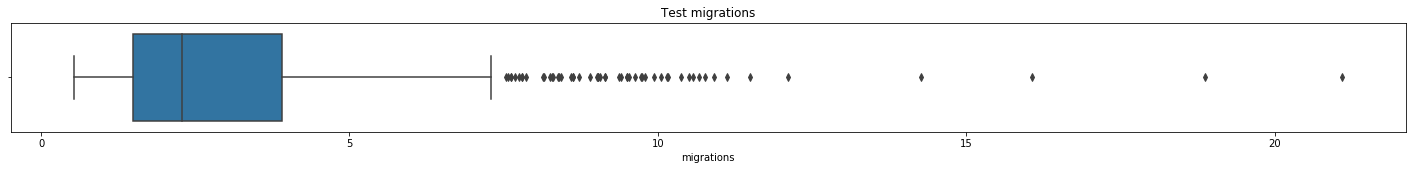

In [110]:
# Check if both samples have a similar distribution
_=plt.figure(figsize=(25, 2))
_=plt.title("Train migrations")
_=sns.boxplot(y_train)
_=plt.figure(figsize=(25, 2))
_=plt.title("Test migrations")
_=sns.boxplot(y_test)

## Model considering as feature inner/outer degree from previous year

### Train Linear Regression & Identify features with higher impact

In [111]:
# Train linear regression and predict migrations
mod = sm.OLS(exog =X_train_degree.as_matrix(), endog=np.array(y_train.astype(float))).fit()
y_pred = mod.predict(np.array(X_test_degree).astype(float))
summary = mod.summary(xname=features_to_scale_degree)

In [112]:
summary.as_csv

<bound method Summary.as_csv of <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     6.537
Date:                Sun, 08 Jul 2018   Prob (F-statistic):           2.66e-16
Time:                        21:02:48   Log-Likelihood:                -8537.4
No. Observations:                3040   AIC:                         1.711e+04
Df Residuals:                    3022   BIC:                         1.722e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

In [113]:
summary = pd.read_csv("../feature_extraction/data/results_gls.csv")
summary = summary.sort_values(by="P-value", ascending=False)

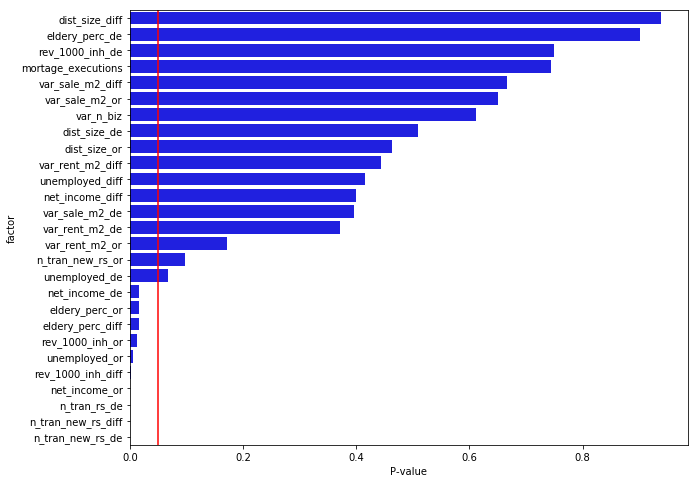

In [114]:
plt.figure(figsize=(10, 8))
sns.barplot(y="factor",x="P-value",data=summary, color="blue")
plt.axvline(x=0.05, color="red")

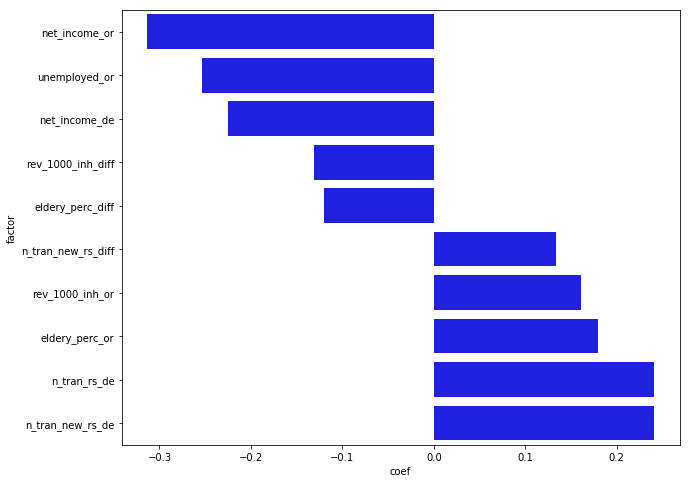

In [115]:
significant_factors = summary[summary["P-value"] < 0.05]
significant_factors = significant_factors.sort_values(by="coef")
plt.figure(figsize=(10, 8))
sns.barplot(y="factor",x="coef",data=significant_factors, color="blue")

Considering a level of significance of 5%, statistically significant factors are:
* Inner and outer degree of origin district
* Inner degree of destination district
* Number of inhabitants in origin and destination district
* Unemployment rate in origin district

### Evaluate performance of the model

In [68]:
print("The RMSE in the test data set is: {:0.2f}\n".format(math.sqrt(mean_squared_error(y_test, y_pred))), 
      "The r2 score in the test data set is: {:0.2f}".format(r2_score(y_test, y_pred)))

The RMSE in the test data set is: 3.98
 The r2 score in the test data set is: -1.61


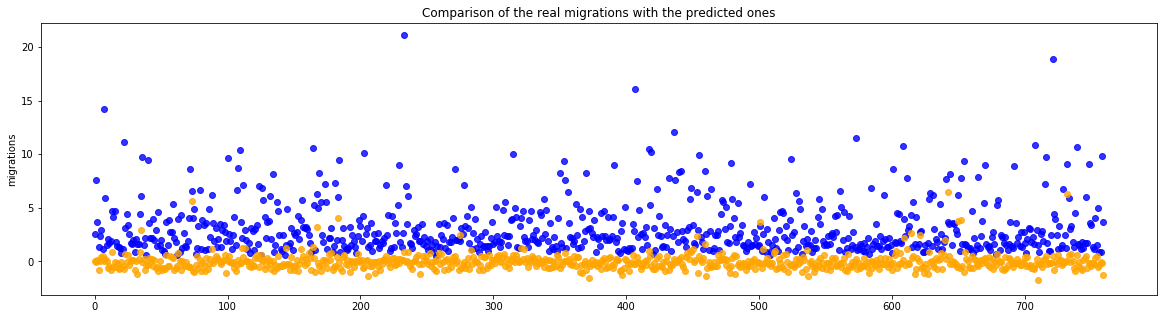

In [69]:
_=plt.figure(figsize=(20, 5))
_=plt.title("Comparison of the real migrations with the predicted ones")
_=sns.regplot(x=np.arange(len(y_test)), y=y_test, fit_reg=False, color="blue")
_=sns.regplot(x=np.arange(len(y_pred)), y=y_pred, fit_reg=False, color="orange")

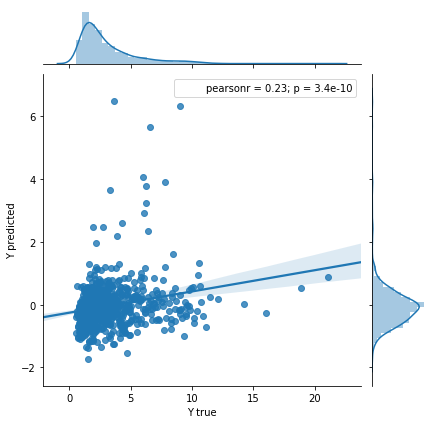

In [70]:
_=sns.jointplot(x=y_test, y=y_pred, kind="reg")
_=plt.xlabel("Y true")
_=plt.ylabel("Y predicted")

## Model without considering as feature inner/outer degree from previous year

### Train Linear Regression & Identify features with higher impact

In [15]:
# Train linear regression and predict migrations
mod = sm.OLS(exog =X_train_wo_degree.as_matrix(), endog=np.array(y_train.astype(float))).fit()
y_pred = mod.predict(np.array(X_test_wo_degree).astype(float))
mod.summary(xname=features_to_scale_wo_degree)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     5.991
Date:                Sat, 07 Jul 2018   Prob (F-statistic):           7.11e-16
Time:                        10:13:18   Log-Likelihood:                -8536.3
No. Observations:                3040   AIC:                         1.711e+04
Df Residuals:                    3020   BIC:                         1.723e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
dist_size_or          -0.0512      0.085     -0.603      0.547      -0.218       0.115
dist_size_de          -0.0409      0.086     -0.478      0.633      -0.209       0.127
net_income_or         -0.3772      0.130     -2.910      0.004      -0.631      -0.123
rev_1000_inh_or        0.2531      0.080      3.177      0.002       0.097       0.409
var_review_or          0.0923      0.077      1.199      0.231      -0.059       0.243
unemployed_or         -0.3516      0.167     -2.107      0.035      -0.679      -0.024
eldery_perc_or         0.2583      0.096      2.694      0.007       0.070       0.446
var_n_biz             -0.0870      0.194     -0.448      0.654      -0.468       0.294
net_income_de         -0.2046      0.130     -1.578      0.115      -0.459       0.050
rev_1000_inh_de       -0.1195      0.092     -1.301      0.193      -0.299       0.061
var_review_de          0.0641      0.076      0.848      0.396      -0.084       0.212
unemployed_de         -0.1165      0.164     -0.712      0.477      -0.437       0.204
eldery_perc_de        -0.0790      0.096     -0.822      0.411      -0.267       0.109
var_sale_m2_or         0.0156      0.117      0.134      0.894      -0.213       0.244
var_rent_m2_or        -0.1523      0.120     -1.266      0.206      -0.388       0.084
var_sale_m2_de        -0.0756      0.117     -0.646      0.518      -0.305       0.154
var_rent_m2_de        -0.0072      0.120     -0.060      0.952      -0.243       0.229
n_tran_rs_or           0.0089      0.039      0.226      0.822      -0.068       0.086
n_tran_new_rs_or       0.0089      0.039      0.226      0.822      -0.068       0.086
n_tran_rs_de           0.2905      0.039      7.468      0.000       0.214       0.367
n_tran_new_rs_de       0.2905      0.039      7.468      0.000       0.214       0.367
mortage_executions     0.1045      0.208      0.502      0.615      -0.303       0.512
==============================================================================
Omnibus:                     1791.276   Durbin-Watson:                   0.804
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21394.116
Skew:                           2.599   Prob(JB):                         0.00
Kurtosis:                      14.912   Cond. No.                     1.29e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.08e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Considering a level of significance of 5%, statistically significant factors are:
* Number of inhabitants in origin and destination district
* Number of Airbnb listings per 1000 inhabitants in origin district
* Unemployment rate in origin district
* Eldery percent in origin district

### Evaluate performance of the model

In [16]:
print("The RMSE in the test data set is: {:0.2f}\n".format(math.sqrt(mean_squared_error(y_test, y_pred))), 
      "The r2 score in the test data set is: {:0.2f}".format(r2_score(y_test, y_pred)))

The RMSE in the test data set is: 3.97
 The r2 score in the test data set is: -1.61


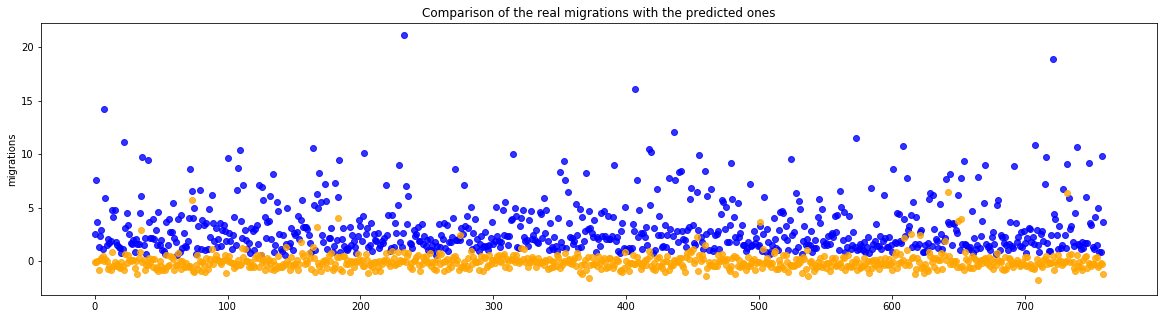

In [17]:
_=plt.figure(figsize=(20, 5))
_=plt.title("Comparison of the real migrations with the predicted ones")
_=sns.regplot(x=np.arange(len(y_test)), y=y_test, fit_reg=False, color="blue")
_=sns.regplot(x=np.arange(len(y_pred)), y=y_pred, fit_reg=False, color="orange")

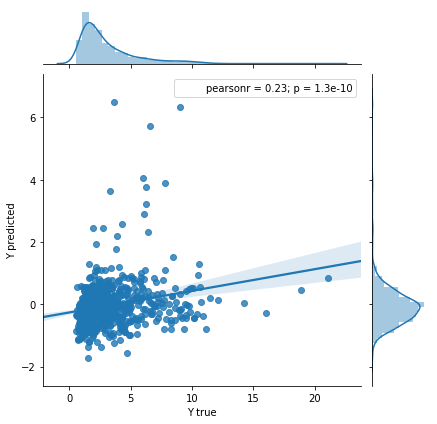

In [18]:
_=sns.jointplot(x=y_test, y=y_pred, kind="reg")
_=plt.xlabel("Y true")
_=plt.ylabel("Y predicted")